<a id='top2'></a>
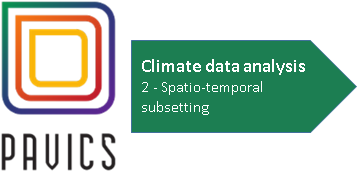

In this second tutorial we will demonstate PAVICS subsetting tools, accessing **ECMWF's ERA5-Land reanalysis**.  PAVICS subsetting relies on the `clisops` library enabling data extraction by:
* [Point location(s)](#point) 
* [Bounding box](#bbox) 
* [Polygon](#poly)
* [Time range](#time)

Advanced topics:
* [Extracting data using a `geopandas.GeoDataFrame`](#adv_gdf)
* [Creating a mask](#adv_mask)
* [Subsetting curvilinear Grids](#adv_curvil)

This tutorial uses <a href="https://clisops.readthedocs.io/en/latest/" target="_blank">clisops</a> for subsetting operations, and <a href="https://geopandas.org/" target="_blank">geopandas</a> to manipulate region geometries.  We re-use part of the data-access tutorial to select a dataset from the PAVICS THREDDS server.
<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>
    

<xarray.Dataset>
Dimensions:  (lat: 800, lon: 1700, time: 26298)
Coordinates:
  * lat      (lat) float32 10.0 10.1 10.2 10.3 10.4 ... 89.5 89.6 89.7 89.8 89.9
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2021-12-31
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    prsn     (time, lat, lon) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
Attributes: (12/26)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    dataset_description:  https://www.ecmwf.int/en/era5-land
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac

[########################################] | 100% Completed | 8.57 sms


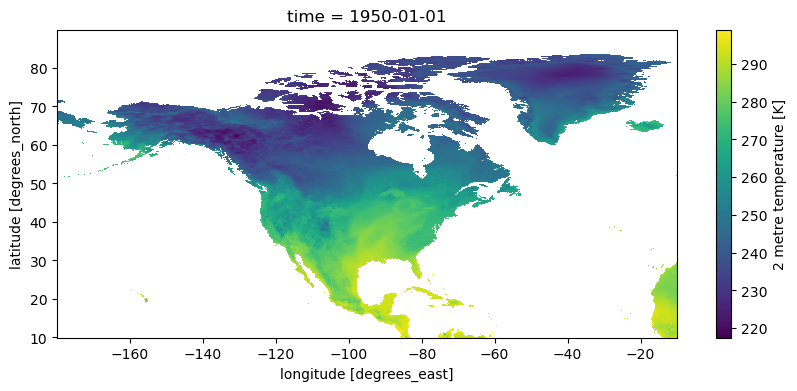

In [1]:
# NBVAL_IGNORE_OUTPUT

import warnings

import xarray as xr
from dask.diagnostics import ProgressBar
from IPython.display import display  # Fancy representation of xarray objects

warnings.simplefilter("ignore")

# DAP link for this demo
ds_url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml"

# xarray.Dataset
ds = xr.open_dataset(ds_url, chunks=dict(time=365, lon=50 * 2, lat=50 * 2))
display(ds)
with ProgressBar():
    a = ds.tasmin.isel(time=0).plot(figsize=(10, 4))

<a id='point'></a>
___
## Subsetting point location(s)

 The `subset_gridpoint` function returns the grid-cell whose center lies closest to the coordinates (latitude, longitude) given. When multiple coordinates are given, the various grid points are ordered along a new  `site` dimension.
 
 Use cases:
 
 - Compare gridded model output to observations at different weather station locations
 - Extract climate time series for cities or other sites of interest

*[return to top of page](#top1)*

<xarray.Dataset>
Dimensions:  (site: 3, time: 26298)
Coordinates:
    lat      (site) float32 46.7 41.0 55.3
    lon      (site) float32 -75.4 -85.0 -65.5
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2021-12-31
Dimensions without coordinates: site
Data variables:
    tas      (time, site) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    tasmin   (time, site) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    tasmax   (time, site) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    pr       (time, site) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    prsn     (time, site) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
Attributes: (12/26)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    dataset_description:  https://www.ecmwf.int/en/era5-land
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac

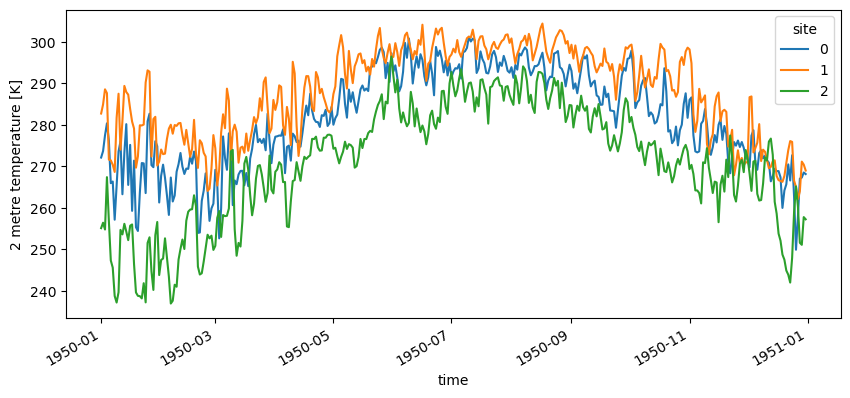

In [2]:
from clisops.core import subset

lon = [-75.4, -85, -65.5]  # Longitude
lat = [46.67, 41, 55.3]  # Latitude

ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat=lat)
display(ds_gridpoint)

# Plot first year of tasmax data
a = ds_gridpoint.tasmax.isel(time=slice(0, 365)).plot.line(x="time", figsize=(10, 4))

The distance to the closest grid point can sometimes be so large that's it's not meaningful anymore. To avoid such cases, a maximum distance can be set using the `tolerance` argument. Also, the actual distance can also be added as a coordinate for manual inspection.

In [3]:
subset.subset_gridpoint(ds, lon=lon, lat=lat, add_distance=True).distance

<xarray.DataArray 'distance' (site: 3)>
array([3.33502567e+03, 0.00000000e+00, 8.49373197e-02])
Coordinates:
    lat       (site) float32 46.7 41.0 55.3
    lon       (site) float32 -75.4 -85.0 -65.5
    distance  (site) float64 3.335e+03 0.0 0.08494
Dimensions without coordinates: site
Attributes:
    units:    m

<a id='bbox'></a>
___
## Subsetting using a boundary box

The  `subset_bbox` function extracts data within latitude and longitude bounds (min, max). 

Use cases

- Extract a rectangular region around a site or region of interest
- Extract tropical, subtropical or polar latitudes

*[return to top of page](#top1)*

<xarray.Dataset>
Dimensions:  (lat: 111, lon: 204, time: 26298)
Coordinates:
  * lat      (lat) float32 44.0 44.1 44.2 44.3 44.4 ... 54.6 54.7 54.8 54.9 55.0
  * lon      (lon) float32 -80.5 -80.4 -80.3 -80.2 ... -60.5 -60.4 -60.3 -60.2
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2021-12-31
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(365, 60, 6), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 60, 6), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 60, 6), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(365, 60, 6), meta=np.ndarray>
    prsn     (time, lat, lon) float32 dask.array<chunksize=(365, 60, 6), meta=np.ndarray>
Attributes: (12/26)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    dataset_description:  https://www.ecmwf.int/en/era5-land
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac

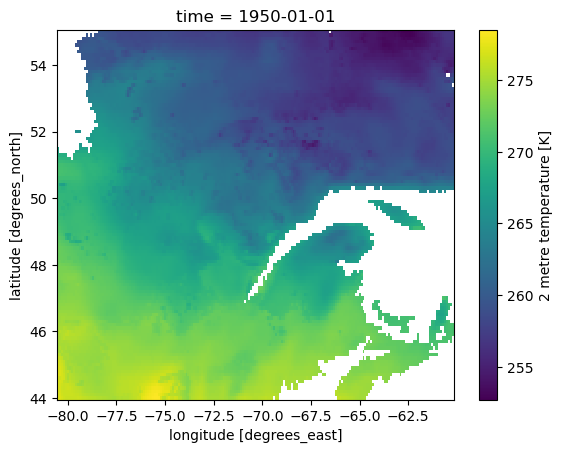

In [4]:
# Specify the longitude and latitude boundaries
lon_bnds = [-80.5, -60.2]
lat_bnds = [44, 55]

ds1 = subset.subset_bbox(ds, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(ds1)

# Plot a map of first timestep
a = ds1.tasmax.isel(time=0).plot()

<a id='poly'></a>
___
## Subsetting using a polygon

The `subset_shape` function can extract data within an arbitrary shape defined by one or multiple polygons. It crops the original grid to the polygon then masks everything outside it. Supported files types include most common GIS formats including shapefile, geojson, and geopackage.

Use cases:

- Analyze climate variables within a country, state or watershed
- Study climate patterns over the Arctic ocean

The example below demonstate subsetting using a geojson layer for southern Quebec administative regions.

*[return to top of page](#top1)*

,isSubreg,AreaKm2,Region,Stride,RegType,geometry
0,1,64619.543075,Abitibi-Témiscamingue,1,admin,"MULTIPOLYGON (((-75.52055 49.00002, -75.52064 ..."
1,1,19429.113878,Capitale-Nationale,1,admin,"MULTIPOLYGON (((-70.78151 46.97156, -70.80159 ..."
2,1,7035.163146,Centre-du-Québec,1,admin,"MULTIPOLYGON (((-72.03655 46.55848, -72.03607 ..."
3,1,15267.682927,Chaudière-Appalaches,1,admin,"MULTIPOLYGON (((-70.64336 47.02725, -70.64995 ..."
4,1,10502.393578,Estrie,1,admin,"MULTIPOLYGON (((-70.41361 45.79600, -70.41368 ..."


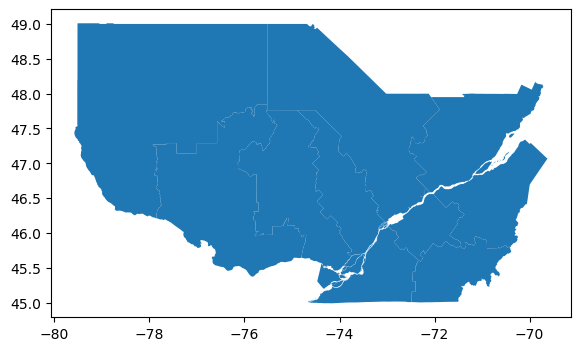

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Explore the polygon layer
regions = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/test_regions.geojson"
)

# Display the first few columns
display(regions.head())

# Plot the layer to see what it looks like
a = regions.plot(figsize=(10, 4))

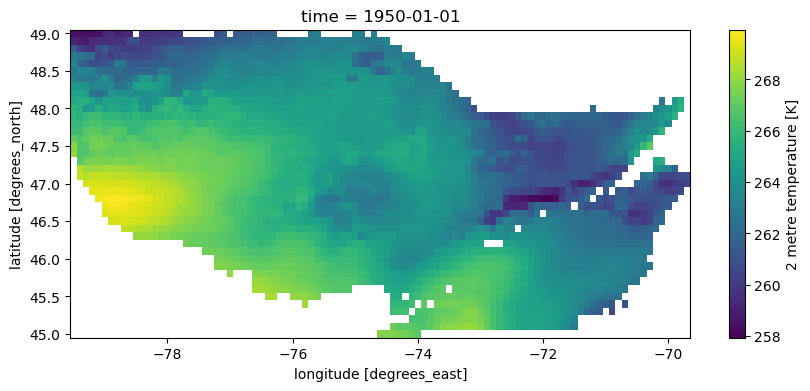

In [6]:
# Subset over all regions
ds_poly = subset.subset_shape(
    ds, shape="/notebook_dir/pavics-homepage/tutorial_data/test_regions.geojson"
)  # use path to layer

a = ds_poly.tasmin.isel(time=0).plot(figsize=(10, 4))

<a id='time'></a>
___
## Subsetting time

The `subset_time` fonction is used to extract a time span. It uses `start_date` and/or `end_date` arguments, which can be given as year, year-month or year-month-day strings. If the start or end date is not given, it defaults to the start or end date of the dataset respectively.

Use cases

- Align datasets to a common starting date
- Compute a climatology over 30-years

*[return to top of page](#top1)*


In [7]:
# Align data to a starting year
ds_sub = subset.subset_time(ds, start_date="1991")
print(
    f"Subset time using start_date only\nstart: {ds_sub.time.min().values};\tend: {ds_sub.time.max().values}\n"
)

# Select a temporal slice
ds_sub = subset.subset_time(ds, start_date="1991-08-05", end_date="2017-06-15")
print(
    f"Subset time using both start_date & end_date\nstart: {ds_sub.time.min().values};\tend: {ds_sub.time.max().values}"
)

Subset time using start_date only
start: 1991-01-01T00:00:00.000000000;	end: 2021-12-31T00:00:00.000000000

Subset time using both start_date & end_date
start: 1991-08-05T00:00:00.000000000;	end: 2017-06-15T00:00:00.000000000



## Advanced subsetting examples
<a id='adv_gdf'></a>
### Extracting data using a `geopandas.GeoDataFrame`
When using `subset_shape` it can sometimes be useful to manipulate the polygon layer before subsetting. For example subsetting using a polygon layer with non-geographic coordinates will result in an error. By loading the layer first as a geodataframe we can perform a reprojection to geographic coordinates (longitude, latitude) on the fly using`to_crs()`

*[return to top of page](#top1)*

There was a problemn... the polygon layer projection is NAD83 / Canada Atlas Lambert
try projecting to WGS 84 ... 


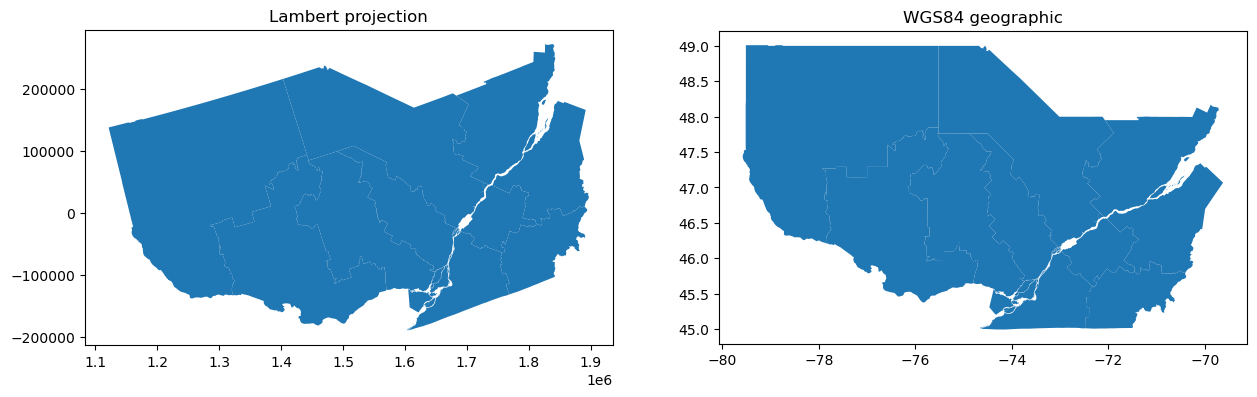

In [8]:
regions_lcc = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/test_regions_lambert.geojson"
)
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
regions_lcc.plot(ax=ax1)
plt.title("Lambert projection")
ax2 = plt.subplot(1, 2, 2)
regions_lcc.to_crs(epsg=4326).plot(ax=ax2)
plt.title("WGS84 geographic")
try:
    ds_poly1 = subset.subset_shape(ds, shape=regions_lcc)
except:
    print(
        f"There was a problemn... the polygon layer projection is {regions_lcc.crs.name}\ntry projecting to WGS 84 ... "
    )

success


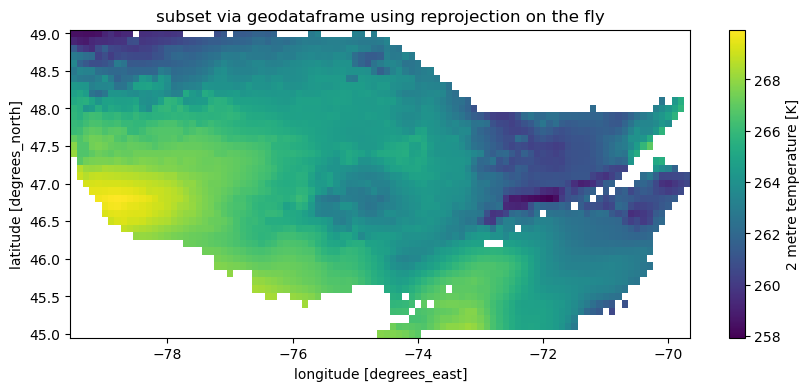

In [9]:
# use projected polygon layer to subset
ds_poly1 = subset.subset_shape(ds, shape=regions_lcc.to_crs(epsg=4326))
a = ds_poly1.tasmin.isel(time=0).plot(figsize=(10, 4))
plt.title("subset via geodataframe using reprojection on the fly")
print("success")

We may also wish to subset the climate only data using a selection of available polygons. For example use only the Montérégie and Estrie subregions.

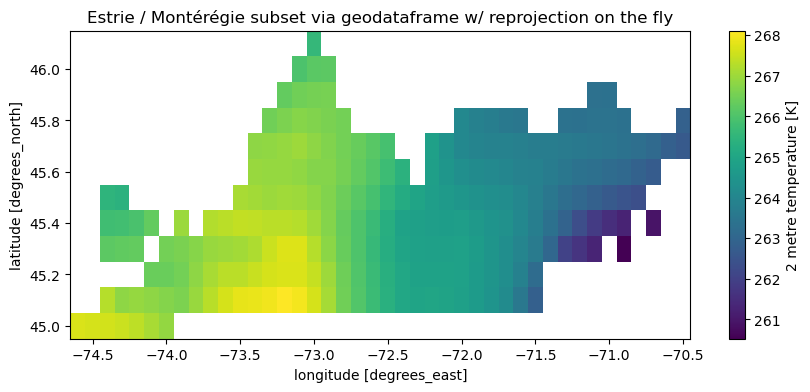

In [10]:
subreg = regions_lcc.loc[(regions_lcc["Region"].isin(["Montérégie", "Estrie"]))]
ds_poly1 = subset.subset_shape(ds, shape=subreg.to_crs(epsg=4326))
a = ds_poly1.tasmin.isel(time=0).plot(figsize=(10, 4))
t = plt.title("Estrie / Montérégie subset via geodataframe w/ reprojection on the fly")

<a id='adv_mask'></a>
### Creating a mask

Mask creation allows subsetting with the entire set of polygons while still allowing manipulation and access to subregions in the resulting dataset.

*[return to top of page](#top1)*

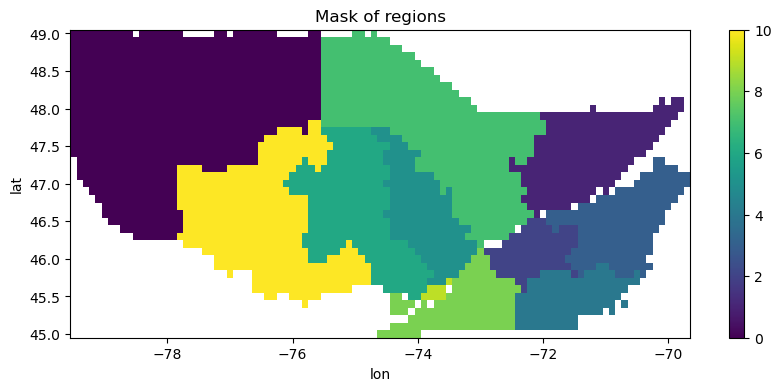

In [11]:
mask = subset.create_mask(
    x_dim=ds_poly.lon, y_dim=ds_poly.lat, poly=regions
).transpose()
a = mask.plot(figsize=(10, 4))
t = plt.title("Mask of regions")

Assign a `region_id` and `region_name` coordinates to the data using the mask
* coordinates can be used to select or summarize data by region

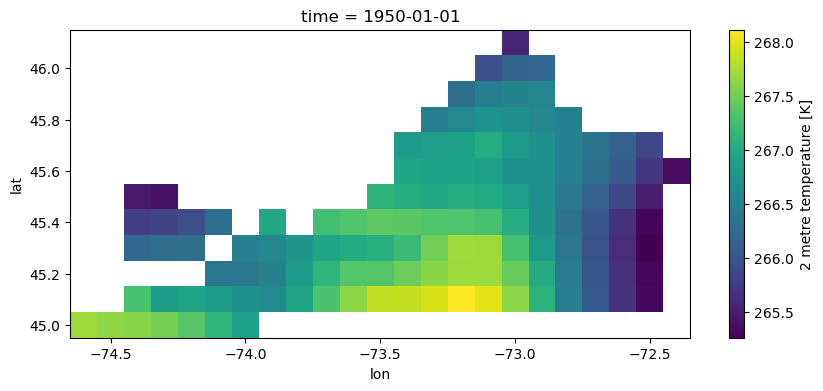

In [12]:
ds_poly = ds_poly.assign_coords(region_id=mask)

# create region_name coordinates
name_array = xr.full_like(ds_poly.region_id, "", dtype=object)
name_field = "Region"
for i, name in enumerate(regions[name_field]):
    name_array = xr.where(ds_poly["region_id"] == i, name, name_array)
    ds_poly = ds_poly.assign_coords(region_name=name_array)


# Plot only a single region by selecting w/ region_name coordinate
a = (
    ds_poly.where(ds_poly.region_name == "Montérégie", drop=True)
    .tasmin.isel(time=0)
    .plot(figsize=(10, 4))
)

<a id='adv_curvil'></a>
### Subsetting Curvilinear Grids
Climate data is often produced using rotated-pole coordinates resulting in irregular or curvlinear lat/lon grids.  Considerable effort has been made in the subsetting tools to seamlessly handle this type of data

PAVICS datasets that use a rotated pole include:

* ESPO-G6-R2 v1.0
* CRCM5-CMIP6
* CaSR (RDRS) v2.1
* ClimEx large ensemble

These dataset will have `rlon` and `rlat` dimensions instead of the typical `lat` and `lon` but can still be subsetted using real-world coordinates via `clisops` functions



*[return to top of page](#top1)*
<div class="alert alert-info"><strong>Info!</strong> Other examples dealing with rotated pole datasets include:  <a href="https://pavics.ouranos.ca/jupyter/hub/user-redirect/lab/tree/tutorial-notebooks/CaSR_basic.ipynb" target="_blank">Canadian Surface Reanalysis</a> and 
<a href="https://pavics.ouranos.ca/jupyter/hub/user-redirect/lab/tree/tutorial-notebooks/climex.ipynb" target="_blank">Analyzing the ClimEx Large Ensemble</a>  

</div>

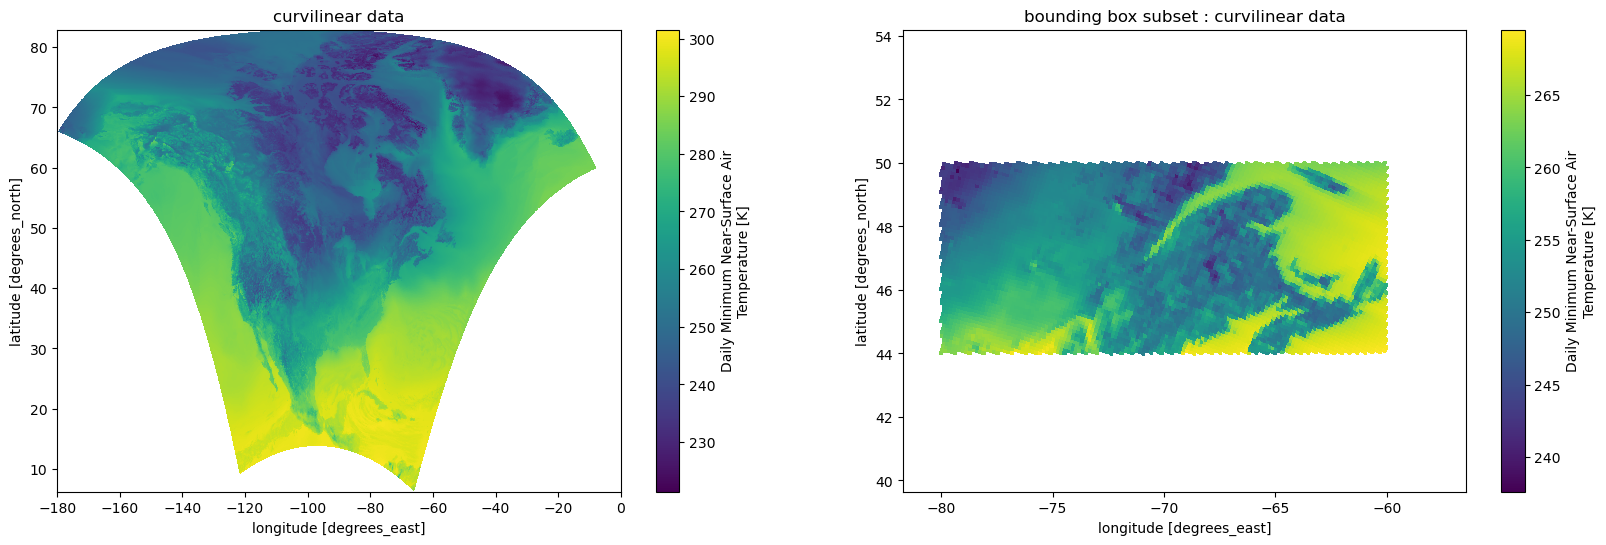

In [13]:
testurl = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/RCM-CMIP6/CORDEX/NAM-12/day/NAM-12_MPI-ESM1-2-LR_ssp370_r1i1p1f1_OURANOS_CRCM5_v1-r1_day_20150101-21001231.ncml"  # TEST_USE_PROD_DATA
ds = xr.open_dataset(testurl, chunks=dict(time=1))
ds = ds.isel(rlon=slice(40, len(ds.rlon)))

fig = plt.figure(figsize=(20, 6))
ax1 = plt.subplot(1, 2, 1)
ds.tasmin.isel(time=0).plot(x="lon", y="lat", ax=ax1)
t = plt.title("curvilinear data")
ax1.set_xlim([-180, 0])
ds_sub = subset.subset_bbox(ds, lat_bnds=[44, 50], lon_bnds=[-80, -60])
ax2 = plt.subplot(1, 2, 2)
ds_sub.tasmin.isel(time=0).plot(x="lon", y="lat", ax=ax2)
t = plt.title("bounding box subset : curvilinear data")

___
### Notes

<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

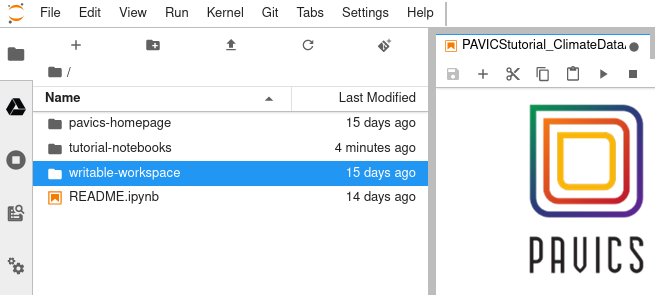

*[return to top of page](#top2)*